# Table Air Temperature

The objective of this script is analyze the air temperature over the PV field comparing it to the desert background

In [1]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import signal
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from scipy import stats
import os
from plotnine.data import mtcars
from itertools import product

### Input and output paths

In [2]:
project_path = 'D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/'   # Weizmann desktop
#project_path = 'C:/Users/rafas/Dropbox/Doutorado/Working/Ketura/'     # notebook
input_path   = project_path + '01_data/'
output_path  = project_path + '02_output/'
graphs_path  = project_path + '03_graphs/'

# Functions

In [3]:
# Loads all data in the folder
def load_all_data(path):
    file_list = sorted(glob.glob(path + '*corr.csv', recursive=True))

    data_list = []
    for filename in file_list:
        fn_without_path = filename.replace(path[:-1], "")[1:]
        print("Loading", fn_without_path)
        
        temp = pd.read_csv(filename)
        temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
        # creating 'Time' column
        temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
        
        temp.loc[temp['Month'] == 'July', 'Season'] = 'Summer'
        temp.loc[temp['Month'] == 'October', 'Season'] = 'Autumn'
        temp.loc[temp['Month'] == 'March', 'Season'] = 'Spring'
        temp.loc[temp['Ecosystem'] == 'Solar', 'Ecosystem'] = 'PV field'
        temp.loc[temp['Ecosystem'] == 'Desert', 'Ecosystem'] = 'Desert background'
        
        data_list.append(temp)
        
    # Combine all the read data
    df = pd.concat(data_list, axis=0, ignore_index=True)
       
    # Convert columns to float
    df['Temperaturek']  = pd.to_numeric(df['TA_average'], downcast="float")
    
    df['Temperature']  = df['Temperaturek'] - 273.15
    
    # Keep only relevant columns
    df = df[['DateTime','Season','Ecosystem','Temperature','Time']]
    
    return(df)

def averaging(temp):
    
    # define mid-day
    #temp = temp.loc[(temp['DateTime'].dt.hour >= 10) & (temp['DateTime'].dt.hour < 15)].copy() 

    # Make mean and std dev
    df_means = temp.groupby(['Season','Ecosystem']).mean().reset_index()
    df_sds   = temp.groupby(['Season','Ecosystem']).std().reset_index()
    # rename columns
    df_means.rename(columns={'Temperature': 'Temperature_mean'}, inplace=True)
    df_sds.rename(columns={'Temperature': 'Temperature_sd'}, inplace=True)
    
    df_means.rename(columns={'T_IMS': 'T_IMS_mean'}, inplace=True)
    df_sds.rename(columns={'T_IMS': 'T_IMS_sd'}, inplace=True)
    
    merged = df_means.merge(df_sds, on=['Season','Ecosystem'])
    
    return(merged)

def diurnal(temp, Ecosystem, Season):
    
    temp = temp.loc[(temp['Ecosystem'] == Ecosystem) & (temp['Season'] == Season)].copy()
    
    # creating 'Time' column
    temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
    
    # Keep only relevant columns
    temp = temp[['Time','Ecosystem','Temperature']]
    
    # Make mean and std dev
    df_means = temp.groupby(['Ecosystem','Time']).mean().reset_index()
    df_sds   = temp.groupby(['Ecosystem','Time']).std().reset_index()
    # rename columns
    df_means.rename(columns={'Temperature': 'Temperature_mean'}, inplace=True)
    
    df_sds.rename(columns={'Temperature': 'Temperature_sd'}, inplace=True)
    
    merged = df_means.merge(df_sds, on=['Ecosystem','Time'])
    
    return(merged)

def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

def ttest_all(temp, category, list_of_test_cols, group_col):
    # Prepare name of categories to test against each other
    group1 = temp[group_col].unique()[0]
    group2 = temp[group_col].unique()[1]
    print('Testing', group1, '&', group2)
    
    # Prepare df for results
    out_df = pd.DataFrame(list(product(list_of_test_cols, temp[category].dropna().unique())), columns=['Parameter', category])
    out_df['p'] = np.nan
    
    # Do t-tests for all combinations
    for col in list_of_test_cols:
        #print('----')
        #print(col)
        for cat in temp[category].dropna().unique():
            #print(cat)
            a = temp.loc[(temp[group_col] == group1) & (temp[category] == cat),col]
            b = temp.loc[(temp[group_col] == group2) & (temp[category] == cat),col]
            t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
            print(col, cat, ':', pvalue_text(t[1]))
            # Add data to resulting df
            out_df.loc[(out_df[category] == cat) & (out_df['Parameter'] == col), 'p'] = pvalue_text(t[1])
    
    return(out_df)

In [4]:
df = load_all_data(input_path)

display (df)

Loading Ketura_all_corr.csv
Loading Yatir_desert_all_corr.csv


,DateTime,Season,Ecosystem,Temperature,Time
0,2019-07-09 20:30:00+00:00,Summer,Desert background,35.649994,20:30
1,2019-07-09 21:00:00+00:00,Summer,Desert background,35.070007,21:00
2,2019-07-09 21:30:00+00:00,Summer,Desert background,34.529999,21:30
3,2019-07-09 22:00:00+00:00,Summer,Desert background,34.119995,22:00
4,2019-07-09 22:30:00+00:00,Summer,Desert background,33.750000,22:30
...,...,...,...,...,...
2872,2015-08-29 23:00:00+00:00,NaN,Yatir,20.880005,23:00
2873,2015-08-29 23:30:00+00:00,NaN,Yatir,20.589996,23:30
2874,2015-08-30 00:00:00+00:00,NaN,Yatir,20.670013,00:00
2875,2015-08-30 00:30:00+00:00,NaN,Yatir,20.450012,00:30


In [5]:
# df['Period'] = 'None'
# df.loc[(df['DateTime'].dt.hour >= 14) & (df['DateTime'].dt.hour < 16), 'Period'] = 'Day'
# df.loc[(df['DateTime'].dt.hour >= 5) & (df['DateTime'].dt.hour < 6), 'Period'] = 'Night'

# display (df)

In [6]:
# day_df = df.loc[(df['Period'] == 'Night')].copy()
# day_df_ecosystem = day_df.loc[(day_df['Ecosystem'] == 'PV field')].copy()
# day_df_season = day_df_ecosystem.loc[(day_df_ecosystem['Season'] == 'Spring')].copy()

# #display(day_df)
# display(day_df_season)

# day_df_season.describe()

In [7]:
# night_df = df.loc[(df['Period'] == 'Night')].copy()

# display(night_df)

# night_df.describe()

In [8]:
mean_df = averaging(df).round(1).copy()

# Move Season to the front
col = mean_df.pop('Season')
mean_df.insert(0, col.name, col)
# Create a text of summarised values (mean + stddev)
mean_df['Temperature'] = mean_df['Temperature_mean'].astype(int).astype(str) + ' (' + mean_df['Temperature_sd'].astype(int).astype(str) + ')'
# Remove the original values
mean_df.drop(['Temperature_mean','Temperature_sd'], axis=1, inplace=True)
#mean_df = mean_df.pivot(index='Ecosystem', columns='Season').stack(level=[0])

#mean_df.to_latex(output_path + 'Ketura_radiative_fluxes_new.tex', index=True)

display(mean_df)

,Season,Ecosystem,Temperature
0,Autumn,Desert background,28 (3)
1,Autumn,PV field,25 (3)
2,Spring,Desert background,26 (4)
3,Spring,PV field,24 (5)
4,Summer,Desert background,34 (4)
5,Summer,PV field,33 (4)


# t-tests

### Seasonal means

In [9]:
# Prepare table
final_df = mean_df.pivot(index='Season', columns='Ecosystem').stack(level=[0])
display(final_df)

final_df = final_df.reset_index()
#final_df['P'] = ''
final_df.rename(columns={'level_1': 'Parameter'}, inplace=True)


p_df = ttest_all(df, 'Season', ['Temperature'], 'Ecosystem')

final_df = final_df.merge(p_df, on = ['Parameter', 'Season'], how='left').copy()

display(final_df)
final_df.to_latex(output_path + 'Ketura_temperature_new.tex', index=False)

,Ecosystem,Desert background,PV field
Season,,,
Autumn,Temperature,28 (3),25 (3)
Spring,Temperature,26 (4),24 (5)
Summer,Temperature,34 (4),33 (4)


Testing Desert background & PV field
Temperature Summer : 0.13
Temperature Spring : <.01
Temperature Autumn : <.001


,Season,Parameter,Desert background,PV field,p
0,Autumn,Temperature,28 (3),25 (3),<.001
1,Spring,Temperature,26 (4),24 (5),<.01
2,Summer,Temperature,34 (4),33 (4),0.13


### Diurnal cycles

In [10]:
#df.drop(['DateTime'], axis=1, inplace=True)
display (df)

# Make mean and std dev
df_means = df.groupby(['Ecosystem','Season','Time']).mean().reset_index()
df_sds   = df.groupby(['Ecosystem','Season','Time']).std().reset_index()
# rename columns
df_means.rename(columns={'Temperature': 'Temperature_mean'}, inplace=True)

df_sds.rename(columns={'Temperature': 'Temperature_sd'}, inplace=True)


all_df_diurnal = df_means.merge(df_sds, on=['Ecosystem','Season','Time'])
all_df_diurnal['Season'] = pd.Categorical(all_df_diurnal['Season'], ordered=True, categories=['Spring','Summer','Autumn'])
# Remove the original values
#all_df_diurnal.drop(['Temperature_mean','Temperature_sd'], axis=1, inplace=True)

display (all_df_diurnal)

,DateTime,Season,Ecosystem,Temperature,Time
0,2019-07-09 20:30:00+00:00,Summer,Desert background,35.649994,20:30
1,2019-07-09 21:00:00+00:00,Summer,Desert background,35.070007,21:00
2,2019-07-09 21:30:00+00:00,Summer,Desert background,34.529999,21:30
3,2019-07-09 22:00:00+00:00,Summer,Desert background,34.119995,22:00
4,2019-07-09 22:30:00+00:00,Summer,Desert background,33.750000,22:30
...,...,...,...,...,...
2872,2015-08-29 23:00:00+00:00,NaN,Yatir,20.880005,23:00
2873,2015-08-29 23:30:00+00:00,NaN,Yatir,20.589996,23:30
2874,2015-08-30 00:00:00+00:00,NaN,Yatir,20.670013,00:00
2875,2015-08-30 00:30:00+00:00,NaN,Yatir,20.450012,00:30


,Ecosystem,Season,Time,Temperature_mean,Temperature_sd
0,Desert background,Autumn,00:00,26.305008,1.660049
1,Desert background,Autumn,00:30,26.118755,1.749759
2,Desert background,Autumn,01:00,25.636257,1.289568
3,Desert background,Autumn,01:30,25.536255,1.380607
4,Desert background,Autumn,02:00,25.613758,1.450246
...,...,...,...,...,...
283,PV field,Summer,21:30,34.381256,1.885256
284,PV field,Summer,22:00,33.765003,1.886762
285,PV field,Summer,22:30,33.008751,1.684616
286,PV field,Summer,23:00,32.476257,1.724313


## Night values

In [11]:
# t-test

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Temperature_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Temperature_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Autumn, night: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Temperature_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Temperature_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Spring, night: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Temperature_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Temperature_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Summer, night: P =', pvalue_text(t[1]))

Autumn, night: P = <.001
Spring, night: P = 0.0
Summer, night: P = <.001


## Day values

In [12]:
# t-test

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Temperature_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Temperature_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Autumn, day: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Temperature_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Temperature_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Spring, day: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Temperature_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Temperature_mean']
t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
print('Summer, day: P =', pvalue_text(t[1]))

Autumn, day: P = 0.0
Spring, day: P = 0.0
Summer, day: P = <.01


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 20.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/temperature_diurnal.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "scale" which is no longer supported as of 3.3 and will become an error two minor releases later
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 20.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/temperature_diurnal.png
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:744: MatplotlibDeprecationWarning: savefig

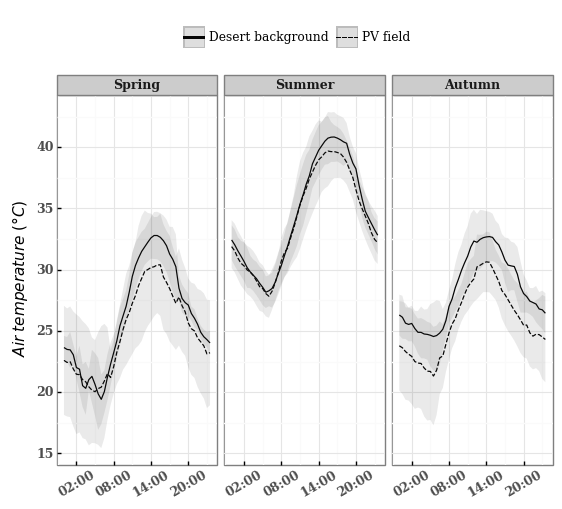

<ggplot: (-9223372030799118188)>

In [13]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
all_df_diurnal['timestamp2'] = pd.to_datetime(all_df_diurnal['Time'], utc=True)

plt = ggplot(all_df_diurnal)
plt = plt + geom_line(aes(x='timestamp2', y='Temperature_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='Temperature_mean - Temperature_sd', ymax='Temperature_mean + Temperature_sd', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$Air \;temperature \;(°C)$', parse=True)
plt = plt + facet_wrap(['Season'])
#plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'temperature_diurnal.pdf', width=20, height=10, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'temperature_diurnal.png', width=20, height=10, units='cm', scale=1.3, dpi=600)


plt

In [14]:
mean_df = averaging(df)

mean_df.to_latex(output_path + 'Ketura_AirTemperature_new.tex', index=False, float_format="{:0.1f}".format)

display(mean_df)

,Season,Ecosystem,Temperature_mean,Temperature_sd
0,Autumn,Desert background,28.307974,3.365931
1,Autumn,PV field,25.735544,3.949778
2,Spring,Desert background,26.222401,4.506220
3,Spring,PV field,24.891878,5.040291
4,Summer,Desert background,34.487621,4.624784
5,Summer,PV field,33.935642,4.509158


In [18]:
display(df)

,DateTime,Season,Ecosystem,Temperature,Time
0,2019-07-09 20:30:00+00:00,Summer,Desert background,35.649994,20:30
1,2019-07-09 21:00:00+00:00,Summer,Desert background,35.070007,21:00
2,2019-07-09 21:30:00+00:00,Summer,Desert background,34.529999,21:30
3,2019-07-09 22:00:00+00:00,Summer,Desert background,34.119995,22:00
4,2019-07-09 22:30:00+00:00,Summer,Desert background,33.750000,22:30
...,...,...,...,...,...
2872,2015-08-29 23:00:00+00:00,NaN,Yatir,20.880005,23:00
2873,2015-08-29 23:30:00+00:00,NaN,Yatir,20.589996,23:30
2874,2015-08-30 00:00:00+00:00,NaN,Yatir,20.670013,00:00
2875,2015-08-30 00:30:00+00:00,NaN,Yatir,20.450012,00:30


## Adding the IMS Yotvata Air Temperature

In [26]:
ims_df = pd.read_excel(input_path + 'Temperature_ims_yotvata.xlsx', header=None, skiprows=1, names=['1','2','Date','Time','Temperature'], na_values='-')
ims_df.drop(['1','2'], axis=1, inplace=True)

# Deal with date & time
ims_df['DateTime'] = pd.to_datetime(ims_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + ims_df['Time'].astype(str), format='%Y-%m-%d %H:%M', utc=True)
ims_df.drop(['Date','Time'], axis=1, inplace=True)

# Format temperature correctly
ims_df['Temperature'] = pd.to_numeric(ims_df['Temperature'])
ims_df.rename(columns={'Temperature': 'T_IMS'}, inplace=True)

display (ims_df)

,T_IMS,DateTime
0,11.800000,2001-01-01 02:00:00+00:00
1,10.400000,2001-01-01 05:00:00+00:00
2,8.500000,2001-01-01 08:00:00+00:00
3,19.000000,2001-01-01 11:00:00+00:00
4,24.200000,2001-01-01 14:00:00+00:00
...,...,...
55062,18.200000,2019-12-31 14:00:00+00:00
55063,16.200000,2019-12-31 17:00:00+00:00
55064,9.600000,2019-12-31 20:00:00+00:00
55065,9.100000,2019-12-31 23:00:00+00:00


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 1540 rows containing missing values.


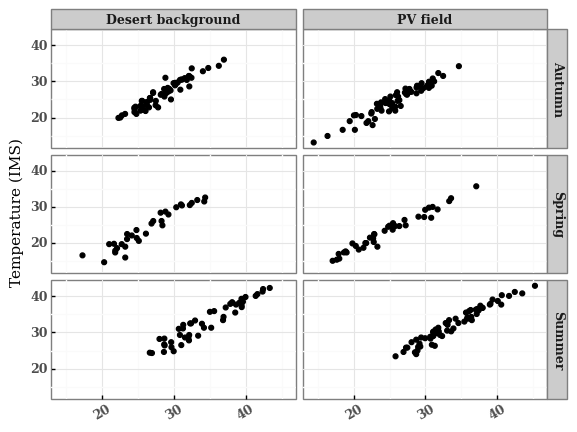

<ggplot: (-9223372030799127532)>


,Season,Ecosystem,Temperature_mean,T_IMS_mean,Temperature_sd,T_IMS_sd
0,Autumn,Desert background,28.307974,26.540625,3.365931,3.915079
1,Autumn,PV field,25.735544,24.669355,3.949778,4.381354
2,Spring,Desert background,26.222401,24.043750,4.506220,5.399040
3,Spring,PV field,24.891878,23.225641,5.040291,5.123101
4,Summer,Desert background,34.487621,32.938298,4.624784,5.376299
5,Summer,PV field,33.935642,32.170968,4.509158,4.939449


In [36]:
all_t = df.merge(ims_df, on='DateTime', how='left')
mean_df = averaging(all_t)

plt = ggplot(all_t.loc[~all_t['Season'].isna()])
plt = plt + geom_point(aes(x='Temperature', y='T_IMS'))
plt = plt + labs(x='Temperature (Mast)', y='Temperature (IMS)', parse=True)
plt = plt + facet_grid('Season ~ Ecosystem')
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
print(plt)

#mean_df.to_latex(output_path + 'Ketura_AirTemperature_new.tex', index=False, float_format="{:0.1f}".format)

display(mean_df)

In [ ]:
all_t['delta_t'] = all_t['']

In [15]:
mean_day_df = averaging(day_df)

mean_day_df.to_latex(output_path + 'Ketura_AirTemperature_day_new.tex', index=False, float_format="{:0.1f}".format)

display(mean_day_df)

NameError: name 'day_df' is not defined

In [16]:
mean_night_df = averaging(night_df)

mean_night_df.to_latex(output_path + 'Ketura_AirTemperature_night_new.tex', index=False, float_format="{:0.1f}".format)

display(mean_night_df)

NameError: name 'night_df' is not defined

In [16]:
diurnal_T_desert_march2018_df = diurnal(df, 'Desert', 'March')
diurnal_T_desert_march2018_df.to_csv(output_path + 'diurnal_T_desert_march2018.csv')

diurnal_T_pv_march2018_df = diurnal(df, 'Solar', 'March')
diurnal_T_pv_march2018_df.to_csv(output_path + 'diurnal_T_pv_march2018.csv')

diurnal_T_desert_october2018_df = diurnal(df, 'Desert', 'October')
diurnal_T_desert_october2018_df.to_csv(output_path + 'diurnal_T_desert_october2018.csv')

diurnal_T_desert_july2019_df = diurnal(df, 'Desert', 'July')
diurnal_T_desert_july2019_df.to_csv(output_path + 'diurnal_T_desert_july2019.csv') 

diurnal_T_pv_october2018_df = diurnal(df, 'Solar', 10)
diurnal_T_pv_october2018_df.to_csv(output_path + 'diurnal_T_pv_october2018.csv')

diurnal_T_pv_july2019_df = diurnal(df, 'Solar', 7)
diurnal_T_pv_july2019_df.to_csv(output_path + 'diurnal_T_pv_july2019.csv') 